In [10]:
import torch.nn as nn
import torch.nn.parallel
import random
import argparse
# from network.resnet import resnet18, resnet34
# from network.pointnet import PointNetCls
from torch.utils.data import DataLoader
import os
import numpy as np
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
# from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from matplotlib import pyplot as plt, font_manager as fm

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

import nb_conda_kernels as kernels

from partial_relaxed_ot import p_rot as p_rot
from partial_relaxed_ot import compute_partial_reg_ot



import matplotlib.font_manager as font_manager

import cvxpy as cp
from matplotlib import cm
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib as mpl


from scipy.stats import entropy


In [11]:
bs = 256


In [12]:
torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 3*bs
np.random.seed(1)
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True)

mnist_dl = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size,
                                       shuffle=True, num_workers=0, worker_init_fn=lambda id: np.random.seed(0))

transform = transforms.Compose(
    [transforms.ToTensor()])

torch.manual_seed(0)
batch_size = bs
np.random.seed(1)
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
emnist_dataset = torchvision.datasets.EMNIST(
    root=image_path, train=True, transform=transform, split='letters', download=True)

emnist_dl = torch.utils.data.DataLoader(
    emnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=lambda id: np.random.seed(0))


In [13]:
Z1, y1 =iter(mnist_dl).next()
Z2, y2 = iter(emnist_dl).next()

annot_y1 = torch.ones_like(y1)
annot_y2 = torch.zeros_like(y2)

Data1 = Z1.squeeze()
Data2 = Z2.squeeze()
X = Data1[0:2*bs]
Y = torch.vstack((Data1[2*bs:],torch.moveaxis(Data2,1,2)))

annot_X = annot_y1[0:2*bs]
annot_Y = torch.concat((annot_y1[2*bs:], annot_y2))

X_vec = X.reshape([X.shape[0],-1])
Y_vec = Y.reshape([Y.shape[0],-1])

# Comparsion

c= 1.0
c= 1.1182868682116351
c= 1.2505655196145868
c= 1.3984909984232523
c= 1.5639141188489016
c= 1.748904622119497
c= 1.9557770726708654
c= 2.1871198175172215
c= 2.4458273711349365
c= 2.7351366310527845
c= 3.058667377270941
c= 3.420467562229416
c= 3.8250639579850194
c= 4.277518794284269
c= 4.7834930961765645
c= 5.349317513635269
c= 5.982071529392835
c= 6.689672036022698
c= 7.480972390526777
c= 8.365873185779897
c= 9.355446124781498
c= 10.462072547604578
c= 11.699598344263643
c= 13.08350719174062
c= 14.631114282676021
c= 16.361782969620297
c= 18.297167035455146
c= 20.4614816212243
c= 22.881806201168853
c= 25.588423395730686
c= 28.61519786168501
c= 32.00000000000001


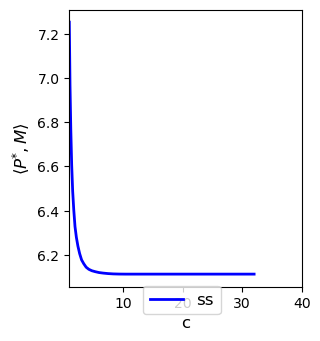

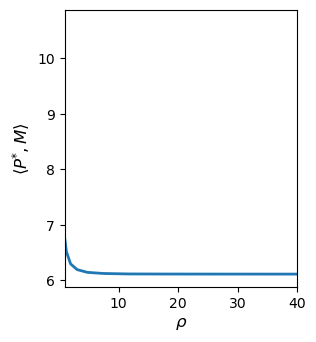

In [16]:
gamma = 0.01
lambd = 1

C = torch.norm(X_vec.unsqueeze(1) - Y_vec, dim=2).numpy()
M = C/np.max(C)
K = np.exp(-M/gamma)


# cs =  [1, 1.25, 1.5, 1.75, 2, 4, 8, 16, 20, 24, 28, 32]
cs = np.logspace(0, np.log10(32), 32)
# rho = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70]
rho = np.logspace(-3,3, len(cs))


C = torch.norm(X_vec.unsqueeze(1) - Y_vec, dim=2).numpy()


ones_n = cp.Constant(np.ones([M.shape[1], 1]))
ones_m = cp.Constant(np.ones([M.shape[0], 1]))


def normalize_1(x): return x/np.sum(x)


m, n = M.shape
mu = np.ones([m, 1])/m
nu = np.ones([n, 1])/n



mu_cp = cp.Constant(mu.reshape([len(mu), 1]))
nu_cp = cp.Constant(nu.reshape([len(nu), 1]))
Mcp = cp.Constant(M)



csfont = {'fontsize': 14}


min_costs_ss = []
min_costs_ipot = []
min_costs_tv = []
min_costs_l2 = []
min_costs_lifty = []
min_costs_lp = []


P_SS = []
P_ipot = []
P_tv = []
P_l2 = []
P_lifty = []
P_lp = []

alpha_ss = np.zeros([len(cs), m])
beta_ss = np.zeros([len(cs), n])
alpha_ipot = np.zeros([len(cs), m])
beta_ipot = np.zeros([len(cs), n])

labels = ["ss", "ss-ipot"]
for idx_c, c in enumerate(cs):
    print("c=", c)



    _, P1, alph1, bet1 = ss_ipot(X_vec, Y_vec, mu, nu, c,  gamma=lambd, max_outer_iter=10000, max_inner_iter=1, wd=2, disp_iter=False, return_map=True)
    P_ipot.append(P1)
    min_costs_ipot.append(np.sum(P1*C))
    alpha_ipot[idx_c] = alph1.squeeze()
    beta_ipot[idx_c] = bet1.squeeze()
    
    
    ### L2 POT
    P2 = p_rot(mu, nu, C, penalty = "l2", reg = 1/rho[idx_c])
    min_costs_l2.append(np.sum(P2*C))
    P_l2.append(P2)
    
    
    ### L1 POT
    P3 = p_rot(mu, nu, C, penalty = "l1", reg = 1/rho[idx_c])
    min_costs_tv.append(np.sum(P3*C))
    P_tv.append(P3)



font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 12}


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3.6))
# axs.plot(cs, min_costs_ss, "r", linewidth=2, label=labels[0])
axs.plot(cs, min_costs_ipot, "b", linewidth=2, label=labels[1])
axs.set_xlabel("c", **csfont)
axs.set_ylabel("$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", **csfont)
axs.set_xlim([1, 40])
# axs.legend(fontsize = 12)
fig.legend(labels, ncol=2, bbox_transform=fig.transFigure,
           loc='lower center',  bbox_to_anchor=(0.5, 0.01), fontsize=12)

plt.show()

fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(3, 3.6))
# axs1.plot(cs, min_costs_ss, "r", linewidth=2, label=labels[0])
axs1.plot(rho, min_costs_tv, linewidth=2, label="TV")
axs1.set_xlabel("$\\rho$", **csfont)
axs1.set_ylabel("$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", **csfont)
axs1.set_xlim([1, 40])
# axs.legend(fontsize = 12)
fig.legend(labels, ncol=2, bbox_transform=fig.transFigure,
           loc='lower center',  bbox_to_anchor=(0.5, 0.01), fontsize=12)

plt.show()


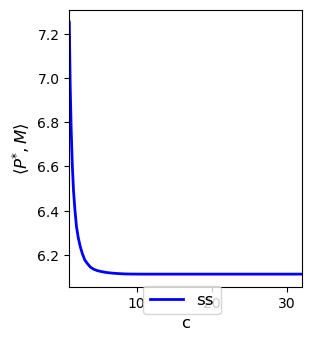

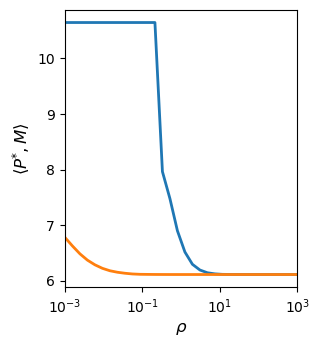

In [18]:

font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 12}


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3.6))
# axs.plot(cs, min_costs_ss, "r", linewidth=2, label=labels[0])
axs.plot(cs, min_costs_ipot, "b", linewidth=2, label=labels[1])
axs.set_xlabel("c", **csfont)
axs.set_ylabel("$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", **csfont)
axs.set_xlim([1, 32])
# axs.legend(fontsize = 12)
fig.legend(labels, ncol=2, bbox_transform=fig.transFigure,
           loc='lower center',  bbox_to_anchor=(0.5, 0.01), fontsize=12)

plt.show()

fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(3, 3.6))
# axs1.plot(cs, min_costs_ss, "r", linewidth=2, label=labels[0])
axs1.semilogx(rho, min_costs_tv, linewidth=2, label="TV")
axs1.semilogx(rho, min_costs_l2, linewidth=2, label="TV")
axs1.set_xlabel("$\\rho$", **csfont)
axs1.set_ylabel("$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", **csfont)
axs1.set_xlim([1e-3, 1e3])
# axs.legend(fontsize = 12)
fig.legend(labels, ncol=2, bbox_transform=fig.transFigure,
           loc='lower center',  bbox_to_anchor=(0.5, 0.01), fontsize=12)

plt.show()


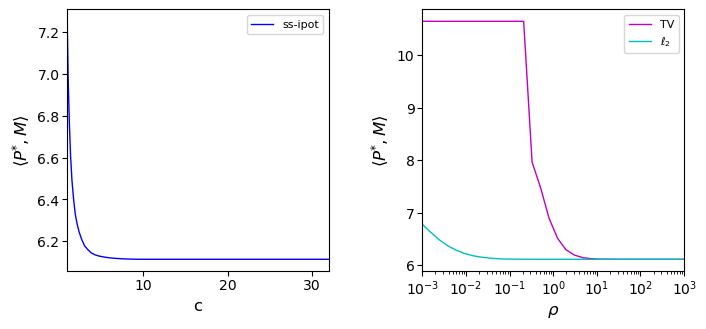

In [21]:
import matplotlib.font_manager as font_manager


font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 14}
labels = ["ss-entropic", "ss-ipot", "ss-lp"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.4, 3.4))


# axs[0].plot(cs, min_costs_ss, "r", linewidth=1, label=labels[0])
axs[0].plot(np.array(cs), min_costs_ipot, "b", linewidth=1, label=labels[1])
# axs[0].plot(np.array(cs), min_costs_lp, "g", linewidth=1, label=labels[2])
axs[0].set_xlabel("c", fontsize=12)
axs[0].set_ylabel(
    "$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", fontsize=12)
axs[0].set_xlim([1, 32])
axs[0].tick_params(axis='both', which='major', labelsize=10, pad=2)
# axs.set_xticks([1,20,40,60,80,100])
axs[0].legend(fontsize=8)
axs[0].set_box_aspect(1)
# fig.legend(labels, ncol=2, bbox_transform=fig.transFigure,
#         loc='lower center',  bbox_to_anchor=(0.5, 0.01), fontsize=12)

# plt.savefig('circle and square-SS_ipot_mincosts.png', bbox_inches='tight', dpi=500, format='png')
# plt.savefig('circle and square-SS_ipot_mincosts.pdf', bbox_inches='tight', dpi = 500, format='pdf')
# plt.savefig('circle and square-SS_ipot_mincosts.svg', bbox_inches='tight', dpi = 500, format='svg')

axs[1].semilogx(np.array(rho), min_costs_tv, "m", linewidth=1, label="TV")
axs[1].semilogx(np.array(rho), min_costs_l2, "c",linewidth=1, label="$\ell_{2}$")
# axs[1].plot(np.array(rho), min_costs_lifty, "y", linewidth=1, label="$\ell_{\infty}$")
axs[1].set_xlabel("$\\rho$", fontsize=12)
axs[1].set_ylabel(
    "$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", fontsize=12)
axs[1].set_xlim([1e-3, 1e3])

axs[1].tick_params(axis='both', which='major', labelsize=10, pad=2)
# axs.set_xticks([1,20,40,60,80,100])
axs[1].legend(fontsize=8)
axs[1].set_box_aspect(1)

fig.savefig('MNIST-SS_comparisons_losses.png', bbox_inches='tight', dpi=500, format='png')
fig.savefig('MNIST-SS_comparisons_losses.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig.savefig('MNIST-SS_comparisons_losses.svg', bbox_inches='tight', dpi=500, format='svg')

plt.show()


c:\Users\bilal\anaconda3\envs\pytorch\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


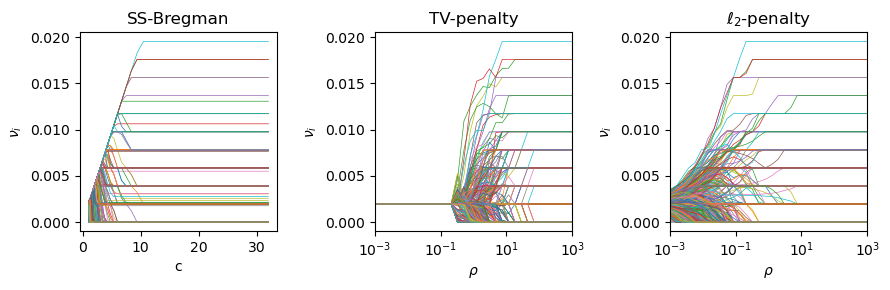

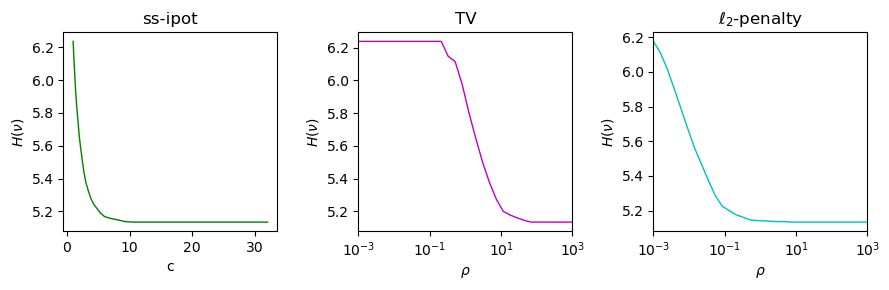

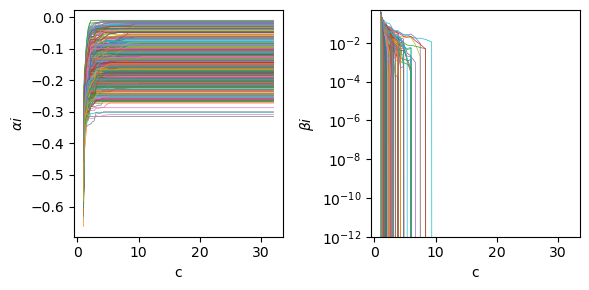

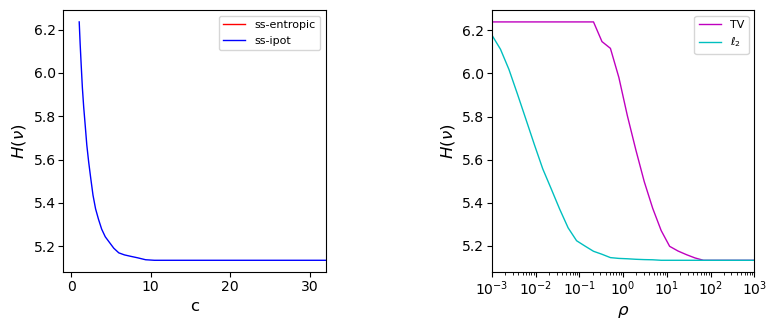

In [192]:
m, n = M.shape


threshold = 1e-8


nu_ss = np.zeros([len(cs), n])
nu_ipot = np.zeros([len(cs), n])
nu_lp = np.zeros([len(cs), n])
nu_tv = np.zeros([len(cs), n])
nu_l2 = np.zeros([len(cs), n])
nu_lifty = np.zeros([len(cs), n])

nu_ss_max = []
nu_ipot_max = []
nu_lp_max = []
nu_tv_max = []
nu_l2_max = []
nu_lifty_max = []

loss_ss = []
loss_ipot = []
loss_lp = []
loss_tv = []
loss_l2 = []
loss_lifty = []

card_ss = []
card_ipor = []
card_lp = []
card_tv = []
card_l2 = []
card_lifty = []

for c in range(0, len(cs)):

    nu_ipot[c] = np.sum(P_ipot[c], axis=0)
    nu_ipot_max.append(np.max(nu_ipot[c]))
    loss_ipot.append(np.sum(P_ipot[c]*M))


    nu_tv[c] = np.sum(P_tv[c], axis=0)
    nu_tv_max.append(np.max(nu_tv[c]))
    loss_tv.append(np.sum(P_tv[c]*M))

    nu_l2[c] = np.sum(P_l2[c], axis=0)
    nu_l2_max.append(np.max(nu_l2))
    loss_l2.append(np.sum(P_l2[c]*M))

    
    
    
nu_ipot[nu_ipot<threshold] = 0 
nu_tv[nu_tv<threshold] = 0 
nu_l2[nu_l2<threshold] = 0 

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

m_slice = len(cs)


axs.flatten()[0].plot(cs[0:m_slice], nu_ipot[0:m_slice], linewidth=0.5)
axs.flatten()[0].set_xlabel("c")
axs.flatten()[0].set_ylabel("$\\nu_{i}$")
axs.flatten()[0].set_title("SS-Bregman")
# axs[1].set_yscale("log")

axs.flatten()[1].semilogx(rho[0:m_slice], nu_tv[0:m_slice], linewidth=0.5)
axs.flatten()[1].set_xlabel("$\\rho$")
axs.flatten()[1].set_ylabel("$\\nu_{i}$")
axs.flatten()[1].set_title("TV-penalty")
axs.flatten()[1].set_xlim([1e-3, 1e3])
# axs[2].set_yscale("log")

axs.flatten()[2].semilogx(rho[0:m_slice], nu_l2[0:m_slice], linewidth=0.5)
axs.flatten()[2].set_xlabel("$\\rho$")
axs.flatten()[2].set_ylabel("$\\nu_{i}$")
axs.flatten()[2].set_title("$\ell_{2}$-penalty")
axs.flatten()[2].set_xlim([1e-3, 1e3])


plt.tight_layout()


fig.savefig('MNIST-SS_comparisons_solution_paths.png', bbox_inches='tight', dpi=500, format='png')
fig.savefig('MNIST-SS_comparisons_solution_paths.pdf', bbox_inches='tight', dpi = 500, format='pdf')
fig.savefig('MNIST-SS_comparisons_solution_paths.svg', bbox_inches='tight', dpi=500, format='svg')


fig2, axs2 = plt.subplots(1, 3, figsize=(9, 3))
axs2.flatten()[0].plot(cs[0:m_slice], entropy(nu_ipot.T)[0:m_slice], 'g', linewidth=1)
axs2.flatten()[0].set_xlabel("c")
axs2.flatten()[0].set_ylabel("$H(\\nu$)")
axs2.flatten()[0].set_title("ss-ipot")


axs2.flatten()[1].semilogx(rho[0:m_slice], entropy(nu_tv.T)[0:m_slice], 'm', linewidth=1)
axs2.flatten()[1].set_xlabel("$\\rho$")
axs2.flatten()[1].set_ylabel("$H(\\nu$)")
axs2.flatten()[1].set_title("TV")
axs2.flatten()[1].set_xlim([1e-3, 1e3])

axs2.flatten()[2].semilogx(rho[0:m_slice], entropy(nu_l2.T)[0:m_slice], 'c',  linewidth=1)
axs2.flatten()[2].set_xlabel("$\\rho$")
axs2.flatten()[2].set_ylabel("$H(\\nu$)")
axs2.flatten()[2].set_title("$\ell_{2}$-penalty")
axs2.flatten()[2].set_xlim([1e-3, 1e3])


plt.tight_layout()

fig2.savefig('MNIST-SS_entropies.png', bbox_inches='tight', dpi=500, format='png')
fig2.savefig('MNIST-SS_entropies.pdf', bbox_inches='tight', dpi = 500, format='pdf')
fig2.savefig('MNIST-SS_entropies.svg', bbox_inches='tight', dpi=500, format='svg')

fig1, axs1 = plt.subplots(1, 2, figsize=(6, 3))

axs1[0].plot(cs[0:m_slice], alpha_ipot[0:m_slice], linewidth=0.5)
axs1[0].set_xlabel("c")
axs1[0].set_ylabel("$\\alpha{i}$")

axs1[1].semilogy(cs[0:m_slice], beta_ipot[0:m_slice], linewidth=0.5)
axs1[1].set_ylim([1e-12, 5e-1])
axs1[1].set_xlabel("c")
axs1[1].set_ylabel("$\\beta{i}$")
plt.tight_layout()


fig1.savefig('MNIST-SS_comparisons_duals_solution_paths.png', bbox_inches='tight', dpi=500, format='png')
fig1.savefig('MNIST-SS_comparisons_duals_solution_paths.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig1.savefig('MNIST-SS_comparisons_duals_solution_paths.svg', bbox_inches='tight', dpi=500, format='svg')

##########################################################################################################
font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 14}
labels = ["ss-entropic", "ss-ipot", "ss-lp"]
fig3, axs3 = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.4))


axs3[0].plot(cs[0:m_slice], entropy(nu_ss.T)[0:m_slice],"r", linewidth=1, label=labels[0])
axs3[0].plot(cs[0:m_slice], entropy(nu_ipot.T)[0:m_slice], "b", linewidth=1, label=labels[1])
axs3[0].set_xlabel("c", fontsize=12)
axs3[0].set_ylabel("$H(\\nu$)", fontsize=12)
axs3[0].set_xlim([-1, 32])
axs3[0].tick_params(axis='both', which='major', labelsize=10, pad=2)
axs3[0].legend(fontsize=8)
axs3[0].set_box_aspect(1)


axs3[1].semilogx(rho, entropy(nu_tv.T)[0:m_slice], "m", linewidth=1, label="TV")
axs3[1].semilogx(rho, entropy(nu_l2.T)[0:m_slice],"c", linewidth=1, label="$\ell_{2}$")
axs3[1].set_xlabel("$\\rho$", fontsize=12)
axs3[1].set_ylabel("$H(\\nu$)", fontsize=12)
axs3[1].set_xlim([1e-3, 1e3])
axs3[1].tick_params(axis='both', which='major', labelsize=10, pad=2)
axs3[1].legend(fontsize=8)
axs3[1].set_box_aspect(1)
plt.tight_layout()


fig3.savefig('MNIST-SS_entropies_c_comparisons.png', bbox_inches='tight', dpi=500, format='png')
fig3.savefig('MNIST-SS_entropies_c_comparisons.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig3.savefig('MNIST-SS_entropies_c_comparisons.svg', bbox_inches='tight', dpi=500, format='svg')
plt.show()


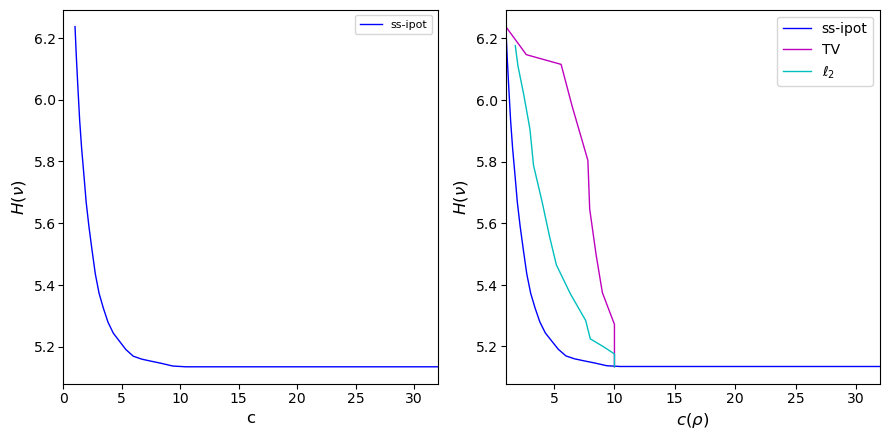

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 14}
labels = ["ss-entropic", "ss-ipot", "ss-lp"]
fig3, axs3 = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.4))


axs3[0].plot(cs[0:m_slice], entropy(nu_ipot.T)[0:m_slice],"b", linewidth=1, label=labels[1])
axs3[0].set_xlabel("c", fontsize=12)
axs3[0].set_ylabel("$H(\\nu$)", fontsize=12)
axs3[0].set_xlim([0, 32])
axs3[0].tick_params(axis='both', which='major', labelsize=10, pad=2)
axs3[0].legend(fontsize=8)
axs3[0].set_box_aspect(1)


c_tv = np.max(nu_tv/nu.T, axis=1)
c_l2 = np.max(nu_l2/nu.T, axis=1)
c_lifty = np.max(nu_lifty/nu.T, axis=1)


axs3[1].plot(cs[0:m_slice], entropy(nu_ipot.T)[0:m_slice], "b", linewidth=1, label=labels[1])

axs3[1].plot(c_tv, entropy(nu_tv.T)[0:m_slice], "m", linewidth=1, label="TV")
axs3[1].plot(c_l2, entropy(nu_l2.T)[0:m_slice], "c", linewidth=1, label="$\ell_{2}$")
axs3[1].set_xlabel("$c$($\\rho$)", fontsize=12)
axs3[1].set_ylabel("$H(\\nu$)", fontsize=12)
axs3[1].set_xlim([1, 32])
axs3[1].tick_params(axis='both', which='major', labelsize=10, pad=2)


axs3[1].legend(ncol=1, bbox_to_anchor=(1, 1))
axs3[1].set_box_aspect(1)
plt.tight_layout()


P_cstar = np.zeros_like(M)

row_idx = list(np.array(range(0, M.shape[0])))
P_cstar[row_idx, list(np.argmin(M, axis=1))] = mu.squeeze()
c_star = np.max(np.sum(P_cstar, axis=0)/nu.squeeze())

fig3.savefig('MNIST-SS_entropies_c_rho_comparisons.png', bbox_inches='tight', dpi=500, format='png')
fig3.savefig('MNIST-SS_entropies_c_rho_comparisons.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig3.savefig('MNIST-SS_entropies_c_rho_comparisons.svg', bbox_inches='tight', dpi=500, format='svg')


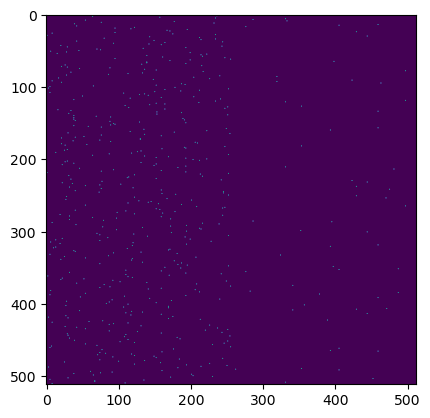

In [38]:
P_cstar = np.zeros_like(M)

row_idx = list(np.array(range(0, M.shape[0])))
P_cstar[row_idx, list(np.argmin(M, axis=1))] = mu.squeeze()
c_star = np.max(np.sum(P_cstar, axis=0)/nu.squeeze())

fig, ax = plt.subplots(1,1)
ax.imshow(P_cstar)
fig.savefig('Toy.png', bbox_inches='tight', dpi=500, format='png')


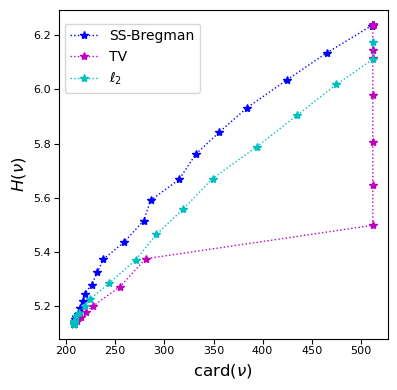

In [185]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 14}
labels = ["SS-Entropic", "SS-Bregman", "SS-LP"]
fig3, axs3 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))


card_nu_ss = np.sum(nu_ss > threshold, axis=1)
card_nu_ipot = np.sum(nu_ipot > threshold, axis=1)
card_nu_lp = np.sum(nu_lp > threshold, axis=1)
card_nu_l2 = np.sum(nu_l2 > threshold, axis=1)
card_nu_tv = np.sum(nu_tv > threshold, axis=1)
card_nu_lifty = np.sum(nu_lifty > threshold, axis=1)




c_tv = np.max(nu_tv/nu.T, axis=1)
c_l2 = np.max(nu_l2/nu.T, axis=1)
c_lifty = np.max(nu_lifty/nu.T, axis=1)


axs3.plot(card_nu_ipot[0:m_slice], entropy(nu_ipot.T)[0:m_slice], ":*b", linewidth=1, label=labels[1])

axs3.plot(card_nu_tv[0:m_slice], entropy(nu_tv.T)[0:m_slice], ":*m", linewidth=1, label="TV")
axs3.plot(card_nu_l2[0:m_slice], entropy(nu_l2.T)[0:m_slice], ":*c", linewidth=1, label="$\ell_{2}$")

axs3.set_xlabel("card($\\nu$)", fontsize=12)
axs3.set_ylabel("$H(\\nu$)", fontsize=12)
axs3.tick_params(axis='both', which='major', labelsize=8, pad=2)

axs3.legend(ncol=1, bbox_to_anchor=(0.45, 0.98))
axs3.set_box_aspect(1)
plt.tight_layout()

fig3.savefig('MNIST-SS_entropies_card_comparisons.png',bbox_inches='tight', dpi=500, format='png')
fig3.savefig('MNIST-SS_entropies_card_comparisons.pdf',bbox_inches='tight', dpi=500, format='pdf')
fig3.savefig('MNIST-SS_entropies_card_comparisons.svg',bbox_inches='tight', dpi=500, format='svg')




In [42]:
sorted_ipot = sorted(zip(nu_ipot[0], annot_Y.numpy()), reverse = True)
_, b = zip(*sorted_ipot)

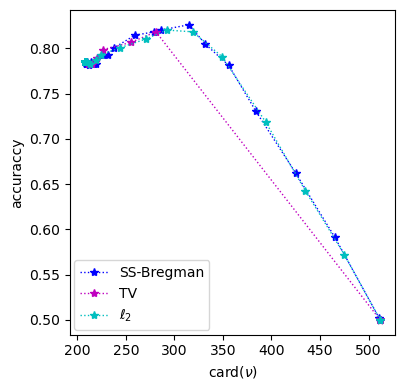

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
m_slice = len(cs)

precision_ss = []
precision_ipot = []
precision_lp = []
precision_tv = []
precision_l2 = []
precision_lifty = []


for c_idx in range(0, len(cs)):

    y_ipot = np.zeros_like(nu_ipot[c_idx])
    y_ipot[nu_ipot[c_idx] > threshold] = 1
    precision_ipot.append(np.mean(y_ipot==annot_Y.numpy()))

    
    y_tv = np.zeros_like(nu_tv[c_idx])
    y_tv[nu_tv[c_idx] > threshold] = 1
    precision_tv.append(np.mean(y_tv==annot_Y.numpy()))
    
    y_l2 = np.zeros_like(nu_l2[c_idx])
    y_l2[nu_l2[c_idx] > threshold] = 1
    precision_l2.append(np.mean(y_l2 == annot_Y.numpy()))
    
ax.plot(card_nu_ipot[0:m_slice], precision_ipot[0:m_slice], ":b*", linewidth=1, label=labels[1])
ax.plot(card_nu_tv, precision_tv[0:m_slice], ":m*", linewidth=1, label="TV")
ax.plot(card_nu_l2, precision_l2[0:m_slice], ":c*", linewidth=1, label="$\ell_{2}$")
ax.set_xlabel("card($\\nu$)")
ax.set_ylabel("accuraccy")

ax.legend(ncol=1, bbox_to_anchor=(0.45, 0.25))
ax.set_box_aspect(1)
plt.tight_layout()


fig.savefig('MNIST-SS_accuraccy_card_comparisons.png', bbox_inches='tight', dpi=500, format='png')
fig.savefig('MNIST-SS_accuraccy_card_comparisons.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig.savefig('MNIST-SS_accuraccy_card_comparisons.svg', bbox_inches='tight', dpi=500, format='svg')

Text(28.0, 0.5, 'accuraccy')

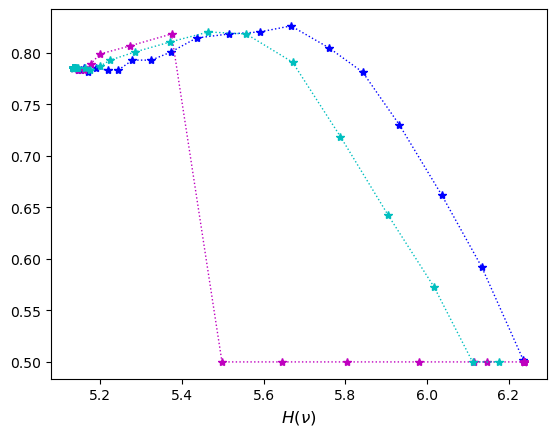

In [155]:
fig, ax = plt.subplots(1, 1)
ax.plot(entropy(nu_ipot.T)[0:m_slice], precision_ipot[0:m_slice], ":*b", linewidth=1, label=labels[1])
ax.plot(entropy(nu_tv.T)[0:m_slice], precision_tv[0:m_slice], ":*m", linewidth=1, label="TV")
ax.plot(entropy(nu_l2.T)[0:m_slice], precision_l2[0:m_slice], ":*c", linewidth=1, label="$\ell_{2}$")

ax.set_xlabel("$H(\\nu$)", fontsize=12)
axs3.set_ylabel("accuraccy", fontsize=12)

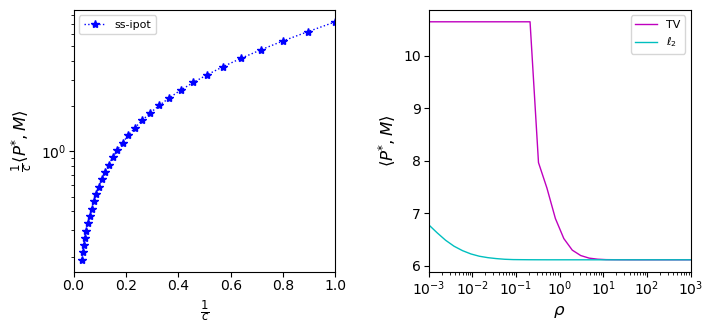

In [156]:
font = font_manager.FontProperties(
    family="Times New Roman", weight='normal', style='normal', size=12)
csfont = {'fontsize': 14}
labels = ["ss-entropic", "ss-ipot", "ss-lp"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.4, 3.4))


axs[0].semilogy(1/np.array(cs), 1/(np.array(cs)) * min_costs_ipot, ":b*", linewidth=1, label=labels[1])
axs[0].set_xlabel("$\\frac{1}{c}$", fontsize=12)
axs[0].set_ylabel("$\\frac{1}{c}\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", fontsize=12)
axs[0].set_xlim([0,1])
axs[0].tick_params(axis='both', which='major', labelsize=10, pad=2)
axs[0].legend(fontsize=8)
axs[0].set_box_aspect(1)

axs[1].plot(np.array(rho), min_costs_tv, "m", linewidth=1, label="TV")
axs[1].semilogx(np.array(rho), min_costs_l2, "c", linewidth=1, label="$\ell_{2}$")
axs[1].set_xlabel("$\\rho$", fontsize=12)
axs[1].set_ylabel(
    "$\langle  \mathbf{\mathit{P}}^{*}, M  \\rangle$", fontsize=12)
axs[1].set_xlim([np.min(rho), np.max(rho)])

axs[1].tick_params(axis='both', which='major', labelsize=10, pad=2)
# axs.set_xticks([1,20,40,60,80,100])
axs[1].legend(fontsize=8)
axs[1].set_box_aspect(1)


fig.savefig('MNIST-SS_comparisons_walmart.png', bbox_inches='tight', dpi=500, format='png')
fig.savefig('MNIST-SS_comparisons_walmart.pdf', bbox_inches='tight', dpi=500, format='pdf')
fig.savefig('MNIST-SS_comparisons_walmart.svg', bbox_inches='tight', dpi=500, format='svg')

plt.show()
